In [395]:
# Import of the packages
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import math
import scipy.stats as sts

In [396]:
class ParameterValueError(Exception):
    """ Custom exception raised when a parameter has an invalid value."""
    pass

In [397]:
class FailedOptimizationError(Exception):
    """ Custom exception raised when a the optimization process fails."""
    pass

In [398]:
class UntrainedModelError(Exception):
    """ Custom exception raised when an untrained model is called to make predictions."""
    pass

In [1286]:
# SVM class
class SVM:
    """ Support Vector Machine (SVM) for regression.
    
    Implementation of SVM for regression with an option to use
    both the original SVM formulation and the alternative v-SVM
    formulation.
    
    Attributes:
        kerType: A string of the type of the desired kernel.
        svmType: A string denoting the SVM type to be used. The string "C" denotes
            the original SVM formulation while the string "V" is used for the 
            alternative v-SVM formulation.
        V: V-variable.
        C: C-variable.
        p: Integer value denoting the degree of the polynomial kernel.
        sigma: Float value denoting the smoothing factor of the Gaussian kernel.
        kappa: Float value denoting the scaling parameter of the sigmoid kernel.
        delta: Float value denoting the translation parameter of the sigmoid kernel.
        eps: Float value denoting the size of the insensitive tube.
        bTrained: boolean value which becomes true once the SVM has been trained.
        a: the 'a' lagrangian multipliers of the SVM.
        a_hat: the 'a-hat' lagrangian multipliers of the SVM.
        b: the bias term of the SVM
        X_sv: the input values of the support vectors.
        Y_sv: the output values of the support vectors.
    """

    EPSILON = 1e-5
   
    def __init__(self, kerType = 'poly', svmType = 'C',
                 V = 0.45, C = 1, p = 1, sigma = 1, 
                 kappa = 1, delta = 1, eps = 0.5):
        """ Initializes the SVM class (constructor).
        
            Raises:
                ParameterValueError: An error occured because a parameter had an
                    invalid value.  
        """
        # Check if the kernel type chosen is valid
        kerTypes = ['linear', 'poly', 'radial', 'sigmoid']
        if kerType not in kerTypes:
            raise ParameterValueError("ParameterValueError: The string " + kerType + \
                                       " does not denote a valid kernel type")
        # Check if the string denoting the svmType has a valid value
        if svmType != 'C' and svmType != 'V':
            raise ParameterValueError('ParameterValueError: ' + svmType, \
                                       " is not a valid SVM type value. Enter 'C' or 'V' as a value. ")
        self.kerType = kerType
        self.svmType = svmType
        self.V = V
        self.C = C
        self.p = p
        self.sigma = sigma
        self.kappa = kappa
        self.delta = delta
        self.eps = eps
        self.bTrained = False

    def kernel(self, x, y):
        """ Kernel computation.
        
        It computes the kernel value based on the dot product
        between two vectors.
        
        Args:
            x: Input vector.
            y: Other input vector.
            
        Returns:
            The computed kernel value.
        """  
        if self.kerType == "linear":
            k = np.dot(x,y) + 1
        elif self.kerType == "poly":
            k = (np.dot(x,y) + 1) ** self.p
        elif self.kerType == "radial":
            k = math.exp(-(np.dot(x-y,x-y))/(2*self.sigma))
        elif self.kerType == "sigmoid":
            k = math.atanh(self.kappa * np.dot(x,y) - self.delta)

        return k
    
    def lagrange(self, params, y, K):
        """ The lagrangian objective function to be minimized.
        
        Args:
            params: A vector with all the a and a-hat Lagrange multipliers.          
            y: Vector with the true output values.
            K: Matrix with the kernel values computed between each input.
        
        Returns:
            The value of the lagrangian for the given parameters.
        """
        N2 = np.shape(params)[0]
        N = int(N2/2)
        a = params[0:N].reshape((N,1))
        a_hat = params[N:N2].reshape((N,1))
        y = y.reshape((N,1))
        if self.svmType == "C":
            L = (1/2) * (a - a_hat).T.dot(K).dot(a - a_hat) \
                + self.eps * np.sum(a + a_hat) \
                - (a - a_hat).T.dot(y)
        elif self.svmType == "V":
            L = (1/2) * (a - a_hat).T.dot(K).dot(a - a_hat) \
                    - (a - a_hat).T.dot(y)
        return L
    
    def train(self, X_tr, Y_tr):
        """ SVM training method
        
        Trains the SVM by minimizing the lagrangian function given the
        training input and output samples.
        
        Args:
            X_tr: A matrix with a training input sample in each row.
            Y_tr: A vector with the output values of each input sample
                in X_tr.
        
        Returns:
            None
        
        Raises:
            FailedOptimizationError: An error occured because the optimization
                of the lagrangian failed.
        """
        N_tr = np.shape(X_tr)[0]
        K = np.zeros((N_tr, N_tr))
        for i in range(N_tr):
            for j in range(N_tr):
                K[i,j] = self.kernel(X_tr[i], X_tr[j])
        args = (Y_tr, K)
        
        bounds = []
        if self.svmType == "C":
            for i in range(0, 2*N_tr):
                bounds.append((0,self.C))
        elif self.svmType == "V":
            for i in range(0, 2*N_tr):
                bounds.append((0,self.C / N_tr))
        
        def constraint_a(params):
            N2 = np.shape(params)[0]
            N = int(N2/2)
            a = params[0:N]
            a_hat = params[N:N2]
            return np.sum(a - a_hat)
        
        def constraint_b(params):
            N2 = np.shape(params)[0]
            N = int(N2/2)
            a = params[0:N]
            a_hat = params[N:N2]
            return self.V * self.C - np.sum(a + a_hat)

        if self.svmType == "C":
            cons = {'type':'eq', 'fun': constraint_a}
        elif self.svmType == "V":
            cons = [{'type':'eq', 'fun': constraint_a},
                {'type':'ineq', 'fun' : constraint_b}]

        
        initial = np.zeros(2*N_tr)
        final = optimize.minimize(self.lagrange, initial, args, \
            bounds=bounds, constraints=cons, method='SLSQP')
        
        if final.success != True:
            raise FailedOptimizationError("FailedOptimizationError: The optimization was not successful.")
        
        a = final.x[0:N_tr]
        a_hat = final.x[N_tr:2*N_tr]
        
        b_sum = 0
        count = 0
        # Average over all estimates of b for samples with a or a_hat between 0 and C
        for i in range(N_tr):
            if a[i] > 0 and a[i] < self.C:
                count += 1
                b_sum += Y_tr[i] - self.eps - (a - a_hat).T.dot(K)[i]
            if a_hat[i] > 0 and a_hat[i] < self.C:
                count += 1
                b_sum += Y_tr[i] + self.eps - (a - a_hat).T.dot(K)[i]
        b = b_sum / count
  
    
        cond_valuable = np.logical_or(a > self.EPSILON, a_hat > self.EPSILON)
        a = a[cond_valuable]
        a_hat = a_hat[cond_valuable]
        X_sv = X_tr[cond_valuable]
        Y_sv = Y_tr[cond_valuable]
        
        self.a = a
        self.a_hat = a_hat
        self.b = b
        self.X_sv = X_sv
        self.Y_sv = Y_sv
        self.bTrained = True
        
    def pred(self, X):
        """Predicts the outputs for a number of input data
        
        Args:
            X: matrix with input data where each row represents a sample.
            
        Returns:
            y: vector with the predicted output for each input sample.
            
        Raises:
            UntrainedModelError: Error that occurs when this function is called
                before calling the 'train' function.
        """
        
        if self.bTrained == False:
            raise UntrainedModelError("UntrainedModelError: The SVM model has not been trained.")
        
        N_sv = np.shape(self.X_sv)[0]
        N = np.shape(X)[0]
        a = self.a.reshape(N_sv,1)
        a_hat = self.a_hat.reshape(N_sv,1)
        K = np.zeros((N_sv, N))
        for i in range(N_sv):
            for j in range(N):
                K[i,j] = self.kernel(self.X_sv[i],X[j])
        y = (a - a_hat).T.dot(K) + self.b
        y = y.reshape(-1)
        return y
    
    def getSV(self):
        return self.X_sv, self.Y_sv

In [1287]:
def printTest(X,Y,X_tst,Y_tst,X_sv,Y_sv,eps):
    plt.plot(X,Y,'ko')
    plt.plot(X_tst, Y_tst, 'b')
    plt.fill_between(X_tst, Y_tst-eps, Y_tst+eps, \
        facecolor='lightblue', interpolate=True, alpha=0.5)
    plt.plot(X_sv, Y_sv, 'go')
    plt.legend(['Not SV', \
                'Regression', \
                'SV', \
                'Insensitive tube'])
    plt.show()

In [1288]:
N_tr = 50
N_ts = 10000

def trans(x):
    N = np.shape(x)[0]
    y = np.sin(x) + 3 + np.random.normal(loc=0, scale=0.1, size=N)
    return y 

x_tr = np.linspace(0,7.5,num=N_tr)
y_tr = trans(x_tr)
x_ts = np.linspace(0,7.5,num=N_ts)
y_ts = trans(x_ts)

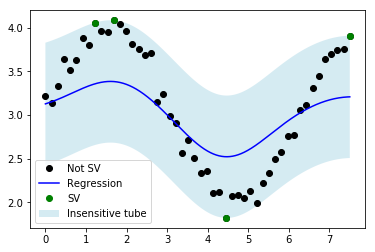

In [1289]:
try:
    epsilon = 0.7
    s = SVM(kerType="radial", C = 10, p = 3, sigma = 1, eps = epsilon)
    s.train(X_tr=x_tr, Y_tr=y_tr)
    y_pred = s.pred(x_ts)
    x_sv, y_sv = s.getSV()
    printTest(x_tr,y_tr,x_ts,y_pred ,x_sv,y_sv,epsilon)
except Exception as e:
    print(e)
    